In [21]:
from sklearn.preprocessing import KBinsDiscretizer  #KBinsDiscretizer를 사용하기 위한 라이브러리로 이산적 형태로 데이터를 바꾸기 위해 선언
import numpy as np 
import time, math, random
from typing import Tuple
import matplotlib.pyplot as plt
from IPython import display
# import gym 
import gym
import pygame                                       #기존 코드에는 없으나 gym의 버전을 맞추기 위해 사용
import sys                                          #기존 코드에는 없으나 너무 느린 학습으로 인해 개선시켜보기 위한 라이브러리
import multiprocessing                              #기존 코드에는 없으나 너무 느린 학습으로 인해 개선시켜보기 위한 라이브러리

In [22]:
env = gym.make('CartPole-v1')                       
#이 코드는 gym의 Open AI library에서 CartPole version1을 실행시키기 위한 환경을 gym.make('CartPole-v1')을 통해 불러와 호출하고 이를 env라는 변수에 할당한다.

In [23]:
#Simple policy function 
policy = lambda _,__,___, tip_velocity : int( tip_velocity > 0 ) #-,--,---은 해당 위치의 인자 무시
#tip_velocity는 끝점의 속도

#policy는 막대의 움직임에 따라 카트가 action을 취할 지침을 의미한다.
#lambda 함수로 정의되었는데 이 lambda함수는 함수를 간단하게 쓰기 위한 코드이다. 
#ex) sum = lambda a,b : a+b 이것은 a와b라는 변수의 합을 sum에 대입하라. 라는 뜻이다. 이것을 여기에 적용해보면 
#끝점의 속도가 양수이면 true이므로 정수형으로 바꾸어 1을 policy에 대입하고, 끝점의 속도가 음수이면 false이므로 정수형으로 바구어 0을 policy에 대입하라는 뜻이다.
#즉, 오른쪽으로 막대가 움직이면 1, 왼쪽으로 막대가 움직이면 0을 policy에 대입하여 향후 Pole이 action을 취할 때 어디로 어떻게 해야하는 지에 영향을 준다.
#_,__,___은 해당 위치의 인자들을 무시하기 위해 작성된 것이다. 왜냐하면 인자로 들어오는 currentstate는 discretizer 함수의 반환값인 angle, velocity 등 여러 정보를 가지고 오기 때문이다.


In [35]:
n_bins = ( 6 , 12 )                                                                 #각도, 각속도에 대한 구간의 개수, 연속적인 값인 각도와 각속도를 6개와 12개로 분할하여 연산 및 판단
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]                  #관측 가능한 공간의 최소값 설정
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]                  #관측 가능한 공간의 최대값 설정

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:                 #연속적인 상태를 이산적으로 변환
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')     #이산 상태를 정수로 인코딩
    est.fit([lower_bounds, upper_bounds ])                                          #객체를 훈련하기 위한 범위를 입력
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))               #각도와 각속도가 연속 상태의 값이므로 [angle, pole_velocity]를 구간화하여 반환한다. map int를 사용하여 정수로 변환하고 튜플로 바꿔 반환한다.

#이산적인 상태 : 연속되지 않고 떨어져있는 상태로 정수와 같이 1,2,3으로 연속되지 않은 상태를 말한다.
#인코딩 : 정보나 데이터를 특정 방식으로 표현하거나 변환하는 것으로 여기서는 연속적인 각도와 각속도 값을 정수로 바꾸는 것을 의미한다.

#est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')는
#주어진 구간 수에 따라 이산 상태를 정수로 인코딩하는 데 사용되는 KBinsDiscretizer 객체를 생성하는 코드이다.
#KBinsDiscretizer는 scikit-learn 라이브러리의 클래스로, 연속적인 값을 주어진 구간(bin) 수에 따라 이산적인 값으로 변환한다.

#이산화(discretization)는 연속적인 상태를 이산적인 상태로 변환하여 각 상태를 구분할 수 있도록 한다.

#n_bins는 구간의 개수를 나타내는 튜플이다. 첫 번째 값은 각도에 대한 구간 수를, 두 번째 값은 각속도에 대한 구간 수를 나타낸다.
#ex) 각도가 360라고 한다면 6개의 구간으로 나눠 0도부터 60도는 0, 60도 부터 120도는 1, 120도 부터 180도는 2, ...으로 나타낼 것을 의미한다. 여기서는 -50radian~50radian을 나눈거려나
#encode='ordinal'은 이산 상태를 정수로 인코딩하는 방법을 지정하는 매개변수이다. 'ordinal'로 설정하면 각 이산 상태를 0부터 순서대로 정수로 인코딩한다.
#strategy='uniform'은 구간을 균등하게 분할하는 방법을 지정하는 매개변수이다. 'uniform'으로 설정하면 구간의 크기를 가능한 한 동일하게 나눈다.

#est.fit([lower_bounds, upper_bounds])는 KBinsDiscretizer 객체를 주어진 하한값과 상한값의 범위로 훈련시키는 과정이다. 
#이를 통해 이산화 객체가 주어진 범위 내에서 이산 상태를 정확하게 구분할 수 있도록 학습된다.

#이후 est.transform([[angle, pole_velocity]])[0]를 사용하여 주어진 연속 상태인 각도와 각속도를 이산화된 상태로 변환한다. 
#변환된 상태는 정수값으로 인코딩되어 있고, tuple(map(int, ...))를 통해 변환된 상태를 정수 튜플로 반환한다. 
# 이때, 첫번째 구간만을 선택하기 위해 [0]을 사용한 것 같은데 그 이유는 잘 모르겠지만 원하고자 하는 값을 호출한 것이기에 사용자가 지정하는 것 같다.

#따라서 est 객체는 연속 상태를 이산 상태로 변환하고, 변환된 상태를 정수로 인코딩하는 데 사용되는 객체이다.



In [34]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape
# n_bins는 이산 상태의 개수
#env.action_space.n은 이 환경에서 가능한 동작의 개수
#이산 상태의 개수와 동작 가능한 개수를 표현할 수 있는 3차원의 Q_table 배열을 만드는데 (6,12,2)이다.
#각도와 각속도를 n_bins 크기로 변환하였으니 이 값을 저장하는 차원에 동작을 나타내는 차원을 더해야하니 모든 동작 가능한 개수를 넣어 0으로 미리 초기화시킨다.
#[[[0. 0.]
#  [0. 0.]
#  [0. 0.]
#  .
#  .
#  .
#  ]
#  [[0. 0.]
#  [0. 0. ]
#  .
#  .
# ]             6 x 12 x 2

(6, 12, 2)
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


In [26]:
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])
#현재 Q_table에서 가장 가치가 높은 것(행동)을 반환한다.
#위에서 언급한 바와 같이 policy는 어떻게 움직일 지에 대한 행동지침이다.

In [27]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    #Q_table의 새로운 상태에서 가장 가치가 높은 값을 최적의 value로 지정한다.
    learned_value = reward + discount_factor * future_optimal_value
    
    #reward란 강화학습에서 사용되는 방식인데 지금 카트가 행동을 잘하고 있다고 판단하면 양수의 값을, 막대를 쓰러뜨리는 등 잘못된 행동을 하고 있으면
    #음수의 값을 주어 값을 감소시킨다. 그래서 결국 가장 크게 Q_Value를 가지도록 현재를 유지시켜야 한다. 그게 옳은 행동일테니까
    #이것은 이 새로운 Q_value를 판단하기 위한 함수이며 env.step()에서 보상, 새로운 상태, discount_factor를 받는다.
    #그렇다면 지금 이 행동이 잘한건지 못한건지에 대한 reward에 이 다음 카트의 행동 중 가장 가치가 높다고 판단되는 future_optimal_value에
    #discount_factor를 곱하여 learned_value 변수에 저장하여 새로운 Q-value로 learned_value값을 반환한다.(value값을 학습하고 초기화 하는 단계이므로)
     
    #discount_factor란 Discount factor는 일반적으로 0과 1 사이의 값으로 설정된다. 
    #값이 1에 가까울수록 미래의 보상을 현재의 보상과 동일한 가치로 간주하고, 값이 0에 가까울수록 미래의 보상을 현재의 보상보다 더 적게 판단한다.
    #강화 학습에서의 목표는 미래에 얻을 수 있는 보상을 최대화하는 것이기 때문에, 
    # discount_factor는 미래 보상을 현재 보상에 비교하여 얼마나 가치있게 여길지를 결정한다.
    
    #learned_value를 저렇게 구하는 이유는 Markov Decision Process에 기반하는데, 여기서는 ValueFunction을 결정하는 공식이 저것이기 때문이다.
    #Value function
    #목표로 하는 것 주변에는 value값이 비교적 높고, terminal값(감점을 받는 구간)주변에는 value값이 비교적 낮다.
    #value를 계산하기 위해 시뮬레이션 해보자
    #value값이 처음에는 0이지만 계속해서 시행착오를 거치며 
    #그 지역의 value값을 업데이트 한다. 실패하면 그 행동의 value를 깎고, 성공하면 그 행동의 value를 올리는 방식이다.
    
# Markov Decision Process is a tuple (S,A,{Psa},r,R)
# S is a set of states
# A is a set of actions

# Psa are the state transition probabilities(s라는 statement에서 a라는 action을 취할 확률
# ex 1에서 2로 가는 확률 = P12)

# r(gamma) is subset of {0,1} is called the discount factor

# R : S X A is the reward function. R가 큰 값으로 움직이기 때문에 그걸 고려해서
# reward를 줘야한다.

#Thus, value = sum(reward * gamma)
#여기서 gamma가 바로 discount_factor이다.
    return learned_value


In [28]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  : #float값으로 반환
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))
#개념
#최적화된 policy를 위해 초기에는 크게크게 업데이트하여 학습을 시키고 점진적으로 LearningRate의 값의 영향을 낮춰 학습보다는 활용을 강화하는 것이 목적이다.
#즉, value값에서 과거의 데이터와 현재의 데이터를 어느 비율로 반영할 것인지에 대한 것이다.
#만일 LearningRate의 값의 영향을 낮추지 않는다면 이전의 학습이 의미가 없어지게 된다. 
# 메인 코드에서 나오겠지만 학습시킬 때, (1-lr)old_value + lr*current_value 공식으로 학습시키게 되는데 lr이 초기에는 크게 하여 과거 경험보단 현재 경험을 중요시하고
#학습횟수가 증가할 수록 1-lr이 커지기 때문에 과거 경험을 더 크게 작용하도록 하여 현재 상황에 적용하는 원리이다.

#원리
#n+1을 25로 나눈 값은 반복될수록 값이 커지게 되며, 이 값이 로그함수에 들어가는 순간,
#n이 커질수록 log10((n+1)/25)의 상승률이 적어지게 된다. 이 장치가 바로 학습률을 느리게 감소시키는 장치이다.
#이 값을 1에서 빼게 되므로 학습률은 감소하게 되는데 이때, min함수에서 1.0과 비교되어 빠져나간다.
#1.0은 학습률에 제한을 걸어둔 것이다. 즉, 학습률은 1.0이상으로 커질 수 없다는 뜻이다.
#이때, 학습률이 너무 작아지면 제대로 된 학습이 이루어지지 않기 때문에 max함수를 활용하여
#최소 학습률 min_rate보다 적게 학습률이 떨어지지 않게 한다.

#적용
#여기서 n은 학습횟수이다. 100번 반복시키기에 100까지 n값은 늘어나게 될 것이다.
#초기 시행횟수 25번 이하에서의 n들은 25로 나누었을 때 1보다 작거나 같게 되므로 1.0과 비교했을 때 1.0보다 크거나 같다.(ex) log10(16/25 == 0.64) < 0, 1.0 - log10(16/25) < 1.0
#때문에 min(1.0,)함수에서 초기 시행단계에서의 최대 학습률을 지정한 것이다. (메인함수에서 old_value의 값이 0이 되도록)
#그 이후부터는 1.0보다 작게 되므로 1.0-math.log10((n+1)/25)의 값이 min에서 선택되게 되고 이들은 min_rate == 0.01와 max함수로 비교된다. 최소학습률을 0.01로 지정하였지만 
#어차피 주어진 코드에서는 100번만 시행하므로 0.01보다 값이 크게 되므로 min함수에서 나온 값이 선택되어 learning_rate가 되는 것이다. 이때, 반환은 float값으로 반환한다.


In [29]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))
#개념
#learningRate와 코드가 같지만, 쓰임새는 다르다.
#learningRate가 학습률을 나타내어 value값을 변화시킬 때 과거 데이터와 현재 데이터의 조화를 담당했다면,
#explorationRate는 탐험률이다. 즉, 어느 정도의 비율로 새로운 행동을 시도해볼 것인가에 대한 여부이다.
#Pole이라는 막대기가 움직이는 것은 random한 값을 생성하여 그 값이 이 탐험률보다 작다면 cart가 새로운 행동을 취하는 것이기 때문에 이 탐험률 역시 점점 작아져야 한다.
#탐험률이 점점 작아지지 않는다면 이미 프로그램은 최적의 cart 움직임을 완성했는데 굳이 새로운 행동을 시도하는 꼴이 될 수 있다.

#원리와 적용은 learningRate와 같다.

SystemExit: 

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


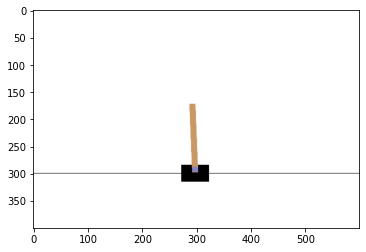

In [30]:
#함수들 주석 달기
#발표 대본

n_episodes = 100
for e in range(n_episodes):
    # Siscretize state into buckets
    current_state, done = discretizer(*env.reset()), False
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment
        obs, reward, done, _ = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state
        

        # Render the cartpole environment
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())    
        display.clear_output(wait=True)
        env.render()
        for event in pygame.event.get():
            if event.type==pygame.QUIT:
                pygame.quit()
                sys.exit()